In [51]:
import pickle
import time
import warnings

import torch
warnings.filterwarnings("ignore")
from pathlib import Path

import autokeras as ak
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_model_summary as pms
from PIL import Image
from autokeras.utils import pickle_from_file
from numpy.random.mtrand import RandomState
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

%matplotlib inline

seed = 42
time_limit_mins = 1
err_param_name = "max_angle"

In [52]:
np.random.seed(seed)

x, y = load_digits(return_X_y=True)
# x = x.astype(np.uint8)
x = x.astype(np.uint8)[:200]
# y = y.astype(np.uint8)
y = y.astype(np.uint8)[:200]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.25, random_state=RandomState(seed))
s = np.sqrt(len(x_train[0])).astype(int)

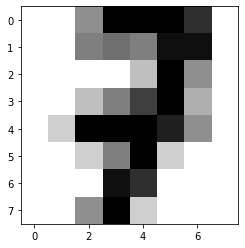

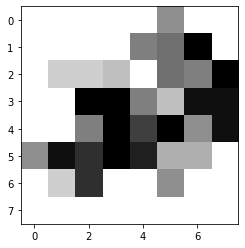

In [53]:
np.random.seed(seed)

def show_img(arr):
    plt.imshow(arr.reshape(s, s), cmap="gray_r")
    plt.show()

def rotate(arr, angle):
    arr = arr.reshape(s, s).astype(float)
    angle = RandomState(seed).uniform(-angle, angle)
    img = Image.fromarray(arr).rotate(angle)
    arr = np.asarray(img)
    arr = np.round(arr).flatten().astype(np.uint8)
    return arr

show_img(x_train[1])
show_img(rotate(x_train[1], 180))

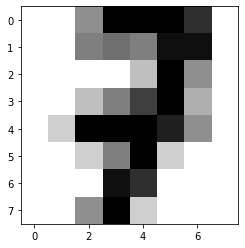

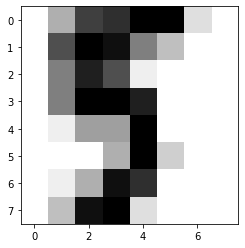

In [54]:
np.random.seed(seed)

err_params = np.linspace(0, 180, num=1)
err_x_train_list = [np.apply_along_axis(rotate, 1, x_train, ep) for ep in err_params]
err_x_test_list = [np.apply_along_axis(rotate, 1, x_test, ep) for ep in err_params]

show_img(err_x_train_list[0][1])
show_img(err_x_test_list[0][1])

In [55]:
np.random.seed(seed)

def get_fitted_model(x_train, y_train, err_param_idx_train):
    model_name = f"autokeras_{err_param_name}_{np.round(err_params[err_param_idx_train], 3)}_time_limit_mins_" \
                 f"{time_limit_mins}"
    model_path = f"models/model_{model_name}.pkl"
    summary_path = f"models/summary_{model_name}.pkl"
    
    if Path(model_path).is_file():
        with open(summary_path, "rb") as f:
            return pickle_from_file(model_path), pickle.load(f), np.nan

    clf = ak.ImageClassifier(augment=False, path="temp", verbose=True)
    x_train = x_train.reshape((len(x_train), s, s, 1))
    time_train = time.time()
    # clf.fit(x_train, y_train, time_limit=60 * time_limit_mins)
    clf.fit(x_train, y_train, time_limit=20)
    time_train = time.time() - time_train
    clf.export_autokeras_model(model_path)
    
    model_summary = pms.summary(clf.cnn.best_model.produce_model(), torch.zeros(1, 1, len(x_train), s ** 2))
    with open(summary_path, "wb") as f:
        pickle.dump(model_summary, f)
    
    return clf, model_summary, time_train

def get_accuracy(clf, x, y):
    x = x.reshape((len(x), s, s, 1))
    y_pred = clf.predict(x)
    return np.round(accuracy_score(y_true=y, y_pred=y_pred), 3)

scores = []
for err_param_idx_train, err_x_train in enumerate(err_x_train_list):
    clf, model_summary, time_train = get_fitted_model(err_x_train, y_train, err_param_idx_train)
    for err_param_idx_test, err_x_test in enumerate(err_x_test_list):
        scores.append({
            f"train_{err_param_name}": np.round(err_params[err_param_idx_train]),
            f"test_{err_param_name}": np.round(err_params[err_param_idx_test]),
            "accuracy": get_accuracy(clf, err_x_test, y_test),
            "time_train": time_train,
            "model_summary": model_summary
        })

scores_df = pd.DataFrame(scores)
scores_df

,train_max_angle,test_max_angle,accuracy,time_train,model_summary
0,0.0,0.0,0.74,NaN,----------------------------------------------...
